## Step 1: Install and Import XGBoost


In [1]:
# Install XGBoost if you haven't already
# Run this in a cell: !pip install xgboost

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("XGBoost version:", xgb.__version__)

# !pip install openpyxl

XGBoost version: 2.1.4


## Step 2: Load and Prepare Data


In [3]:
# Load your engineered features
comps_df = pd.read_csv('../data/model_ready/comps_pairs_model_ready.csv')
candidates_df = pd.read_csv('../data/model_ready/candidates_pair_model_ready.csv')

# Add labels
comps_df['is_good_comp'] = 1
candidates_df['is_good_comp'] = 0

print(f"Positive examples (comps): {len(comps_df)}")
print(f"Negative examples (candidates): {len(candidates_df)}")
print(f"Imbalance ratio: 1:{len(candidates_df) / len(comps_df):.1f}")

Positive examples (comps): 264
Negative examples (candidates): 9820
Imbalance ratio: 1:37.2


## Step 3: XGBoost Strategy 1 - Using scale_pos_weight


In [4]:
# Combine all data (yes, ALL of it!)
all_data = pd.concat([comps_df, candidates_df], ignore_index=True)

# Define features
feature_cols = [
    'gla_diff', 'lot_size_diff', 'bedroom_diff', 'bathroom_diff',
    'room_count_diff', 'same_property_type', 'same_storey_type',
    'sold_recently_90'
]

# Prepare X and y
X = all_data[feature_cols].copy()
y = all_data['is_good_comp']

# Handle missing values
print("Handling missing values...")
for col in ['gla_diff', 'lot_size_diff', 'bedroom_diff', 'bathroom_diff', 'room_count_diff']:
    X[col] = X[col].fillna(X[col].median())

for col in ['same_property_type', 'same_storey_type', 'sold_recently_90']:
    X[col] = X[col].fillna(0)

# Calculate scale_pos_weight (this is the magic for imbalanced data!)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
print(f"\nscale_pos_weight = {scale_pos_weight:.1f}")
print("This tells XGBoost to give positive examples more importance")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} examples")
print(f"Test set: {len(X_test)} examples")

Handling missing values...

scale_pos_weight = 37.2
This tells XGBoost to give positive examples more importance

Training set: 8067 examples
Test set: 2017 examples


## Step 4: Train XGBoost Model


In [5]:
# Your existing model creation code stays the same
xgb_model = xgb.XGBClassifier(
    # Basic parameters
    n_estimators=100,                    # Number of trees
    max_depth=6,                        # Maximum tree depth (prevent overfitting)
    learning_rate=0.3,                  # Step size shrinkage (default is good)
    
    # Imbalanced data parameter
    scale_pos_weight=scale_pos_weight,  # Handle imbalance!
    
    # Regularization parameters (prevent overfitting)
    reg_alpha=0.1,                      # L1 regularization
    reg_lambda=1.0,                     # L2 regularization
    
    # Other useful parameters
    random_state=42,                    # Reproducibility
    n_jobs=-1,                          # Use all CPU cores
    eval_metric='logloss'               # Evaluation metric
)

# FIXED VERSION - Remove the problematic parameters from fit()
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)  # Just use the basic fit() method

print("Training complete!")

# Remove this line since we're not using early stopping
# print(f"Best iteration: {xgb_model.best_iteration}")

Training XGBoost model...
Training complete!


# Step 5: Make Predictions and Evaluate


Accuracy: 0.977
ROC AUC Score: 0.964

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1964
           1       0.55      0.62      0.58        53

    accuracy                           0.98      2017
   macro avg       0.77      0.80      0.79      2017
weighted avg       0.98      0.98      0.98      2017



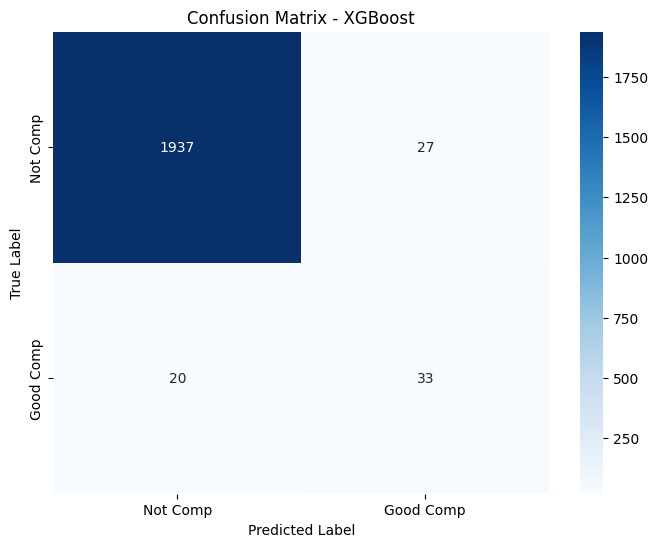

In [6]:
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = (y_pred == y_test).mean()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC Score: {auc_score:.3f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Comp', 'Good Comp'],
            yticklabels=['Not Comp', 'Good Comp'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Step 6: ROC Curve Analysis


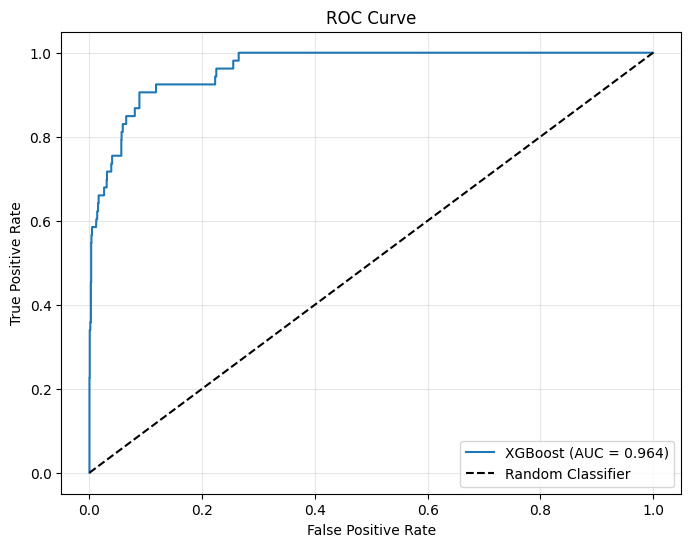

Optimal threshold: 0.006


In [7]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")

## Step 7: Feature Importance


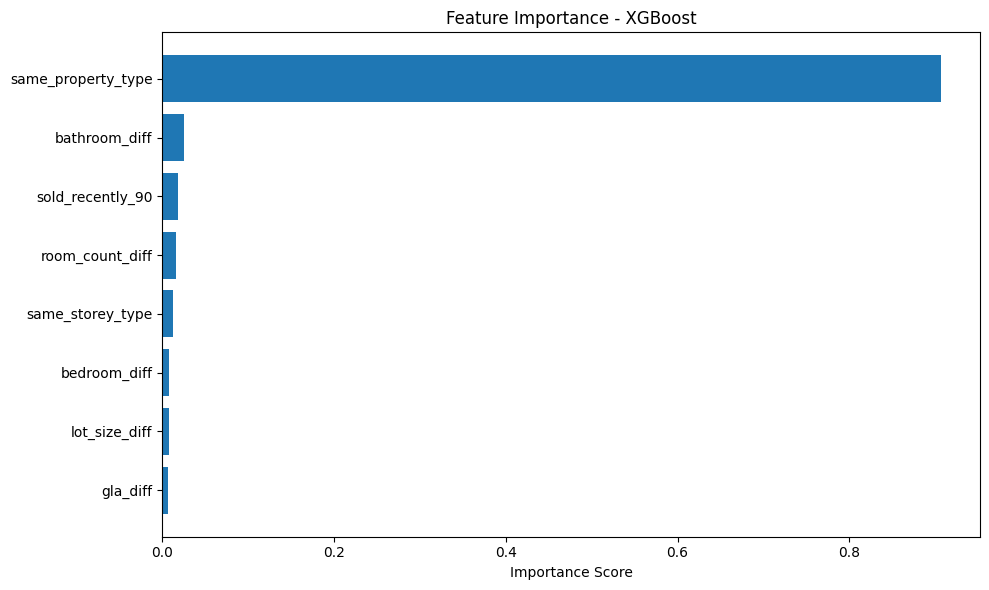

Top 3 most important features:
- sold_recently_90: 0.019
- bathroom_diff: 0.025
- same_property_type: 0.907


In [8]:
# Get feature importance
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

# Print top features
print("Top 3 most important features:")
for _, row in feature_importance.tail(3).iterrows():
    print(f"- {row['feature']}: {row['importance']:.3f}")

# Step 8: XGBoost Strategy 2 - Sampling Approach

In [9]:
# Create balanced dataset through sampling
negative_samples = []

for order_id in comps_df['orderID'].unique():
    order_candidates = candidates_df[candidates_df['orderID'] == order_id]
    if len(order_candidates) > 0:
        n_positives = len(comps_df[comps_df['orderID'] == order_id])
        n_to_sample = min(n_positives * 3, len(order_candidates))
        sampled = order_candidates.sample(n=n_to_sample, random_state=42)
        negative_samples.append(sampled)

negative_df = pd.concat(negative_samples, ignore_index=True)
balanced_data = pd.concat([comps_df, negative_df], ignore_index=True)

# Prepare features
X_balanced = balanced_data[feature_cols].fillna(0)
y_balanced = balanced_data['is_good_comp']

# Split data
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Train XGBoost without scale_pos_weight (data is already balanced)
xgb_balanced = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1
)

xgb_balanced.fit(X_train_bal, y_train_bal)

# Evaluate
y_pred_bal = xgb_balanced.predict(X_test_bal)
print("Balanced Sampling Approach Results:")
print(classification_report(y_test_bal, y_pred_bal))

Balanced Sampling Approach Results:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       157
           1       0.80      0.75      0.78        53

    accuracy                           0.89       210
   macro avg       0.86      0.85      0.85       210
weighted avg       0.89      0.89      0.89       210



# Step 9: Compare Both Approaches


AUC Score - Weighted approach: 0.985
AUC Score - Balanced approach: 0.984


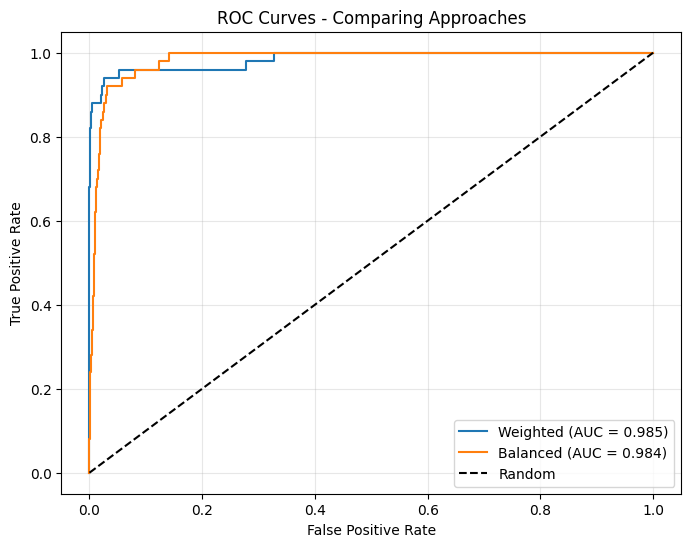

In [10]:
# Make predictions on the same test set for fair comparison
# First, create a common test set from candidates
test_candidates = candidates_df.sample(n=1000, random_state=42)
test_comps = comps_df.sample(n=50, random_state=42)
test_combined = pd.concat([test_comps, test_candidates], ignore_index=True)

X_test_common = test_combined[feature_cols].fillna(0)
y_test_common = test_combined['is_good_comp']

# Predictions from both models
pred_weighted = xgb_model.predict_proba(X_test_common)[:, 1]
pred_balanced = xgb_balanced.predict_proba(X_test_common)[:, 1]

# Compare AUC scores
auc_weighted = roc_auc_score(y_test_common, pred_weighted)
auc_balanced = roc_auc_score(y_test_common, pred_balanced)

print(f"AUC Score - Weighted approach: {auc_weighted:.3f}")
print(f"AUC Score - Balanced approach: {auc_balanced:.3f}")

# Plot both ROC curves
plt.figure(figsize=(8, 6))
for pred, label, auc in [(pred_weighted, 'Weighted', auc_weighted), 
                         (pred_balanced, 'Balanced', auc_balanced)]:
    fpr, tpr, _ = roc_curve(y_test_common, pred)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparing Approaches')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 10: Make Final Predictions on All Candidates


Results by Subject Property (first 10):
        is_good_comp_pred comp_probability             
                      sum             mean    max count
orderID                                                
4723364                 8            0.019  0.379    33
4742669                13            0.020  0.982   174
4752865                11            0.003  0.062   141
4755196                 9            0.007  0.764   165
4756192                 9            0.001  0.450   537
4756320                25            0.030  0.660   104
4756829                 6            0.002  0.170   151
4757939                19            0.009  0.998   245
4757966                 5            0.001  0.016   141
4758025                15            0.007  0.233   109


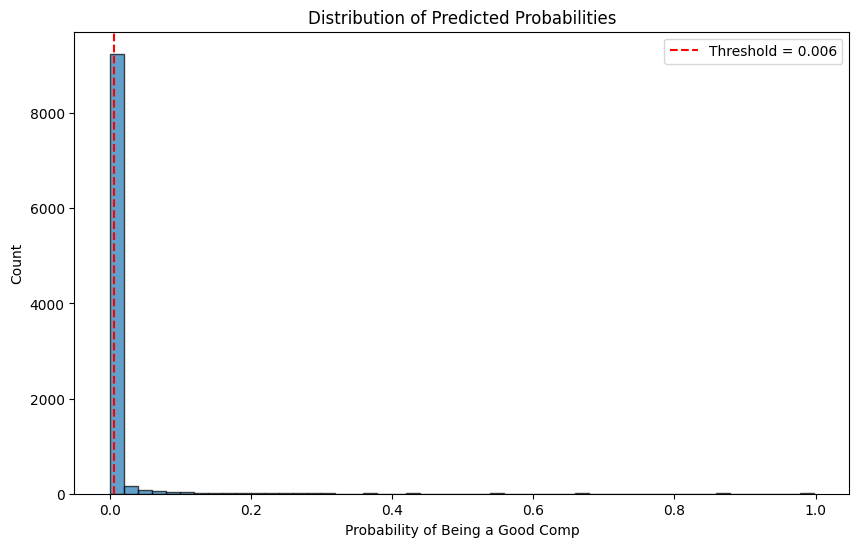


Predictions saved! Found 928 good comps out of 9820 candidates


In [12]:
# Use the best model (typically the weighted approach)
best_model = xgb_model  # or xgb_balanced based on results

# Prepare all candidates
X_all_candidates = candidates_df[feature_cols].fillna(0)

# Make predictions
probabilities = best_model.predict_proba(X_all_candidates)[:, 1]

# Add to dataframe
candidates_df['comp_probability'] = probabilities
candidates_df['is_good_comp_pred'] = (probabilities >= optimal_threshold).astype(int)

# Analyze results by orderID
results_by_order = candidates_df.groupby('orderID').agg({
    'is_good_comp_pred': 'sum',
    'comp_probability': ['mean', 'max', 'count']
}).round(3)

print("Results by Subject Property (first 10):")
print(results_by_order.head(10))

# Show distribution of probabilities
plt.figure(figsize=(10, 6))
plt.hist(probabilities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(optimal_threshold, color='red', linestyle='--', 
            label=f'Threshold = {optimal_threshold:.3f}')
plt.xlabel('Probability of Being a Good Comp')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

# Save results
output = candidates_df[['orderID', 'comp_probability', 'is_good_comp_pred']]
output.to_csv('../model/xgboost_predictions.csv', index=False)
print(f"\nPredictions saved! Found {candidates_df['is_good_comp_pred'].sum()} good comps out of {len(candidates_df)} candidates")

# Getting Top 3 Predictions per Subject & Hyperparameter Tuning

## Step 1: Basic Hyperparameter Tuning

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
import time

# Assuming you have X_train, y_train, X_test, y_test from previous steps
# If not, load and prepare data first

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Basic parameter grid - good starting point
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Create base model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

# Use RandomizedSearchCV (faster than GridSearchCV)
print("Starting hyperparameter tuning...")
print("This will take a few minutes...")

start_time = time.time()

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

print(f"\nTuning completed in {time.time() - start_time:.1f} seconds")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.4f}")

# Get best model
best_model = random_search.best_estimator_

scale_pos_weight: 37.23
Starting hyperparameter tuning...
This will take a few minutes...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuning completed in 2.6 seconds
Best parameters: {'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV score: 0.9662


## Step 2: Advanced Tuning with Early Stopping


In [14]:
# More focused tuning around best parameters
# Extract best parameters and create ranges around them
best_params = random_search.best_params_
focused_param_grid = {
    'max_depth': [max(3, best_params['max_depth']-1), 
                  best_params['max_depth'], 
                  min(10, best_params['max_depth']+1)],
    'learning_rate': [best_params['learning_rate'] * 0.5, 
                      best_params['learning_rate'], 
                      best_params['learning_rate'] * 1.5],
    'n_estimators': [200, 300, 400],  # More trees with early stopping
    'subsample': [best_params['subsample'] - 0.1, 
                  best_params['subsample'], 
                  min(1.0, best_params['subsample'] + 0.1)],
    'colsample_bytree': [best_params['colsample_bytree'] - 0.1, 
                         best_params['colsample_bytree'], 
                         min(1.0, best_params['colsample_bytree'] + 0.1)],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]  # L2 regularization
}

# Train with early stopping
print("\nFine-tuning with early stopping...")

# Create validation set for early stopping
from sklearn.model_selection import train_test_split
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Best parameters so far
final_params = random_search.best_params_.copy()
final_params.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'auc',
    'n_estimators': 300  # Will use early stopping
})

# FIXED VERSION - Train final model WITHOUT early stopping in fit()
print("Training final model...")
final_model = xgb.XGBClassifier(**final_params)

# Simple training without early stopping parameters
final_model.fit(X_train_es, y_train_es)

print("Training complete!")

# Evaluate on test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("\nTest Set Performance:")
from sklearn.metrics import roc_auc_score, classification_report
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fine-tuning with early stopping...
Training final model...
Training complete!

Test Set Performance:
ROC AUC: 0.9712

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1964
           1       0.50      0.68      0.58        53

    accuracy                           0.97      2017
   macro avg       0.75      0.83      0.78      2017
weighted avg       0.98      0.97      0.98      2017



## Step 3: Save Best Model Parameters


In [17]:
# Save best parameters for future use
best_params_df = pd.DataFrame([final_model.get_params()])
best_params_df.to_csv('../model/best_xgboost_params.csv', index=False)
print("\nBest parameters saved to 'best_xgboost_params.csv'")

# Save the model itself
final_model.save_model('../model/best_xgboost_model.json')
print("Model saved to 'best_xgboost_model.json'")


Best parameters saved to 'best_xgboost_params.csv'
Model saved to 'best_xgboost_model.json'


## Step 4: Make Predictions on All Candidates


In [18]:
# Load candidates data if not already loaded
# candidates_df = pd.read_csv('data/model_ready/candidates_pair_model_ready.csv')

# Prepare features
X_candidates = candidates_df[feature_cols].copy()

# Handle missing values (same as training)
for col in ['gla_diff', 'lot_size_diff', 'bedroom_diff', 'bathroom_diff', 'room_count_diff']:
    X_candidates[col] = X_candidates[col].fillna(X_candidates[col].median())

for col in ['same_property_type', 'same_storey_type', 'sold_recently_90']:
    X_candidates[col] = X_candidates[col].fillna(0)

# Get probabilities using the best model
probabilities = final_model.predict_proba(X_candidates)[:, 1]

# Add to candidates dataframe
candidates_df['comp_probability'] = probabilities
candidates_df['comp_rank'] = candidates_df.groupby('orderID')['comp_probability'].rank(
    ascending=False, method='first'
)

print(f"Predictions made for {len(candidates_df)} candidates")
print(f"Probability range: {probabilities.min():.3f} to {probabilities.max():.3f}")

Predictions made for 9820 candidates
Probability range: 0.000 to 0.991


## Step 5: Get Top 3 Candidates per Subject


In [19]:
# Get top 3 candidates for each subject
top_3_per_subject = candidates_df[candidates_df['comp_rank'] <= 3].copy()

# Sort by orderID and rank
top_3_per_subject = top_3_per_subject.sort_values(['orderID', 'comp_rank'])

# Select important columns for the output
output_columns = [
    'orderID',
    'comp_rank',
    'comp_probability',
    # Original property details
    'gla_clean',
    'lot_size_clean',
    'bedrooms_clean', 
    'bathrooms_clean',
    'room_count_clean',
    'property_type_clean',
    'stories_clean',
    'close_date_clean',
    # Differences from subject
    'gla_diff',
    'lot_size_diff',
    'bedroom_diff',
    'bathroom_diff',
    'room_count_diff',
    'same_property_type',
    'same_storey_type',
    'sold_recently_90',
    'sold_recently_180'
]

# Make sure all columns exist
available_columns = [col for col in output_columns if col in top_3_per_subject.columns]
top_3_output = top_3_per_subject[available_columns].copy()

# Rename columns for clarity
top_3_output = top_3_output.rename(columns={
    'comp_rank': 'rank',
    'comp_probability': 'probability_score',
    'gla_clean': 'candidate_gla',
    'lot_size_clean': 'candidate_lot_size',
    'bedrooms_clean': 'candidate_bedrooms',
    'bathrooms_clean': 'candidate_bathrooms',
    'room_count_clean': 'candidate_rooms',
    'property_type_clean': 'candidate_property_type',
    'stories_clean': 'candidate_stories',
    'close_date_clean': 'candidate_sale_date'
})

# Round numerical values for readability
numerical_cols = ['probability_score', 'gla_diff', 'lot_size_diff', 
                  'bedroom_diff', 'bathroom_diff', 'room_count_diff']
for col in numerical_cols:
    if col in top_3_output.columns:
        top_3_output[col] = top_3_output[col].round(3)

print(f"\nTop 3 candidates selected for {top_3_output['orderID'].nunique()} subjects")
print("\nSample of top candidates:")
print(top_3_output.head(6))


Top 3 candidates selected for 88 subjects

Sample of top candidates:
      orderID  rank  probability_score  candidate_gla  candidate_lot_size  \
9800  4723364   1.0              0.476         1300.0              3636.0   
9787  4723364   2.0              0.261         3227.0                 NaN   
9803  4723364   3.0              0.188         1210.0               101.0   
1910  4742669   1.0              0.940          839.0              5392.0   
1945  4742669   2.0              0.530         1078.0              4994.0   
1909  4742669   3.0              0.437          850.0              5995.0   

      candidate_bedrooms  candidate_bathrooms  candidate_rooms  \
9800                 3.0                  2.0              8.0   
9787                 5.0                  3.5             17.0   
9803                 2.0                  2.0              8.0   
1910                 3.0                  2.0              5.0   
1945                 5.0                  2.0              N

## Step 6: Create a More Detailed Summary


In [21]:
# Create a summary with subject information included
# First, load subject data
subjects_df = pd.read_csv('../data/cleaned/subjects_cleaned.csv')

# Create a comprehensive output
top_3_detailed = []

for order_id in top_3_output['orderID'].unique():
    # Get subject info
    subject = subjects_df[subjects_df['orderID'] == order_id].iloc[0]
    
    # Get top 3 candidates for this subject
    candidates = top_3_output[top_3_output['orderID'] == order_id]
    
    for _, candidate in candidates.iterrows():
        row = {
            # Subject information
            'orderID': order_id,
            'subject_gla': subject['gla_clean'],
            'subject_lot_size': subject['lot_size_clean'],
            'subject_bedrooms': subject['bedrooms_clean'],
            'subject_bathrooms': subject['bathrooms_clean'],
            'subject_property_type': subject['property_type_clean'],
            'subject_stories': subject['stories_clean'],
            'subject_effective_date': subject['effective_date_clean'],
            
            # Candidate information
            'rank': int(candidate['rank']),
            'probability_score': candidate['probability_score'],
            'candidate_gla': candidate['candidate_gla'],
            'candidate_lot_size': candidate['candidate_lot_size'],
            'candidate_bedrooms': candidate['candidate_bedrooms'],
            'candidate_bathrooms': candidate['candidate_bathrooms'],
            'candidate_property_type': candidate['candidate_property_type'],
            'candidate_stories': candidate['candidate_stories'],
            'candidate_sale_date': candidate['candidate_sale_date'],
            
            # Comparison metrics
            'gla_difference': candidate['gla_diff'],
            'lot_size_difference': candidate['lot_size_diff'],
            'bedroom_difference': candidate['bedroom_diff'],
            'bathroom_difference': candidate['bathroom_diff'],
            'is_same_property_type': candidate['same_property_type'],
            'is_same_storey_type': candidate['same_storey_type'],
            'sold_within_90_days': candidate['sold_recently_90'],
            'sold_within_180_days': candidate['sold_recently_180']
        }
        top_3_detailed.append(row)

# Convert to DataFrame
top_3_detailed_df = pd.DataFrame(top_3_detailed)

print(f"\nDetailed summary created with {len(top_3_detailed_df)} rows")
print(f"Covering {top_3_detailed_df['orderID'].nunique()} subjects")


Detailed summary created with 264 rows
Covering 88 subjects


## Step 7: Save Results with Summary Statistics


In [27]:
# Save detailed results
top_3_detailed_df.to_csv('../data/results/top_3_comparables_per_subject.csv', index=False)
print("\nDetailed results saved to 'top_3_comparables_per_subject.csv'")

# Create a summary statistics file
summary_stats = []

for order_id in top_3_detailed_df['orderID'].unique():
    subject_candidates = top_3_detailed_df[top_3_detailed_df['orderID'] == order_id]
    
    stats = {
        'orderID': order_id,
        'avg_probability_top3': subject_candidates['probability_score'].mean(),
        'max_probability': subject_candidates['probability_score'].max(),
        'min_probability': subject_candidates['probability_score'].min(),
        'avg_gla_diff': subject_candidates['gla_difference'].mean(),
        'avg_bedroom_diff': subject_candidates['bedroom_difference'].mean(),
        'pct_same_property_type': subject_candidates['is_same_property_type'].mean() * 100,
        'pct_sold_within_90_days': subject_candidates['sold_within_90_days'].mean() * 100
    }
    summary_stats.append(stats)

summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df = summary_stats_df.round(3)

# Save summary
summary_stats_df.to_csv('../model/top_3_summary_statistics.csv', index=False)
print("Summary statistics saved to 'top_3_summary_statistics.csv'")

# Display summary
print("\nSummary Statistics (first 10 subjects):")
print(summary_stats_df.head(10))


Detailed results saved to 'top_3_comparables_per_subject.csv'
Summary statistics saved to 'top_3_summary_statistics.csv'

Summary Statistics (first 10 subjects):
   orderID  avg_probability_top3  max_probability  min_probability  \
0  4723364                 0.308            0.476            0.188   
1  4742669                 0.636            0.940            0.437   
2  4752865                 0.254            0.337            0.204   
3  4755196                 0.722            0.785            0.679   
4  4756192                 0.006            0.011            0.004   
5  4756320                 0.911            0.955            0.855   
6  4756829                 0.303            0.533            0.062   
7  4757939                 0.690            0.810            0.578   
8  4757966                 0.004            0.004            0.003   
9  4758025                 0.314            0.351            0.281   

   avg_gla_diff  avg_bedroom_diff  pct_same_property_type  \
0    

## Step 8: Create a User-Friendly Report


In [28]:
# Create a formatted Excel report with multiple sheets
with pd.ExcelWriter('../data/results/comparable_analysis_report.xlsx', engine='openpyxl') as writer:
    # Sheet 1: Top 3 Comparables
    top_3_detailed_df.to_excel(writer, sheet_name='Top 3 Comparables', index=False)
    
    # Sheet 2: Summary Statistics
    summary_stats_df.to_excel(writer, sheet_name='Summary Statistics', index=False)
    
    # Sheet 3: Model Performance
    performance_df = pd.DataFrame({
        'Metric': ['ROC AUC Score', 'Best CV Score', 'Total Candidates', 'Total Subjects'],
        'Value': [
            roc_auc_score(y_test, y_pred_proba),
            random_search.best_score_,
            len(candidates_df),
            len(subjects_df)
        ]
    })
    performance_df.to_excel(writer, sheet_name='Model Performance', index=False)
    
    # Sheet 4: Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    feature_importance.to_excel(writer, sheet_name='Feature Importance', index=False)

print("\nComprehensive report saved to 'comparable_analysis_report.xlsx'")


Comprehensive report saved to 'comparable_analysis_report.xlsx'


## Step 9: Quick Analysis of Results


In [29]:

# Analyze the quality of top 3 selections
print("\n=== ANALYSIS OF TOP 3 COMPARABLES ===")

# Overall statistics
print(f"\nOverall Probability Scores:")
print(f"Average: {top_3_detailed_df['probability_score'].mean():.3f}")
print(f"Median: {top_3_detailed_df['probability_score'].median():.3f}")
print(f"Min: {top_3_detailed_df['probability_score'].min():.3f}")
print(f"Max: {top_3_detailed_df['probability_score'].max():.3f}")

# Quality indicators
high_quality = top_3_detailed_df['probability_score'] > 0.7
medium_quality = (top_3_detailed_df['probability_score'] > 0.5) & (top_3_detailed_df['probability_score'] <= 0.7)
low_quality = top_3_detailed_df['probability_score'] <= 0.5

print(f"\nQuality Distribution:")
print(f"High Quality (>0.7): {high_quality.sum()} ({high_quality.mean()*100:.1f}%)")
print(f"Medium Quality (0.5-0.7): {medium_quality.sum()} ({medium_quality.mean()*100:.1f}%)")
print(f"Low Quality (≤0.5): {low_quality.sum()} ({low_quality.mean()*100:.1f}%)")

# Subjects with concerning results
concerning_subjects = summary_stats_df[summary_stats_df['max_probability'] < 0.5]
print(f"\nSubjects with no high-confidence comparables: {len(concerning_subjects)}")
if len(concerning_subjects) > 0:
    print("These subjects might need manual review:")
    print(concerning_subjects['orderID'].tolist()[:10])  # Show first 10


=== ANALYSIS OF TOP 3 COMPARABLES ===

Overall Probability Scores:
Average: 0.448
Median: 0.397
Min: 0.001
Max: 0.991

Quality Distribution:
High Quality (>0.7): 87 (33.0%)
Medium Quality (0.5-0.7): 31 (11.7%)
Low Quality (≤0.5): 146 (55.3%)

Subjects with no high-confidence comparables: 34
These subjects might need manual review:
[4723364, 4752865, 4756192, 4757966, 4758025, 4758529, 4759561, 4759846, 4760530, 4761220]


## Step 10: Visualization of Results

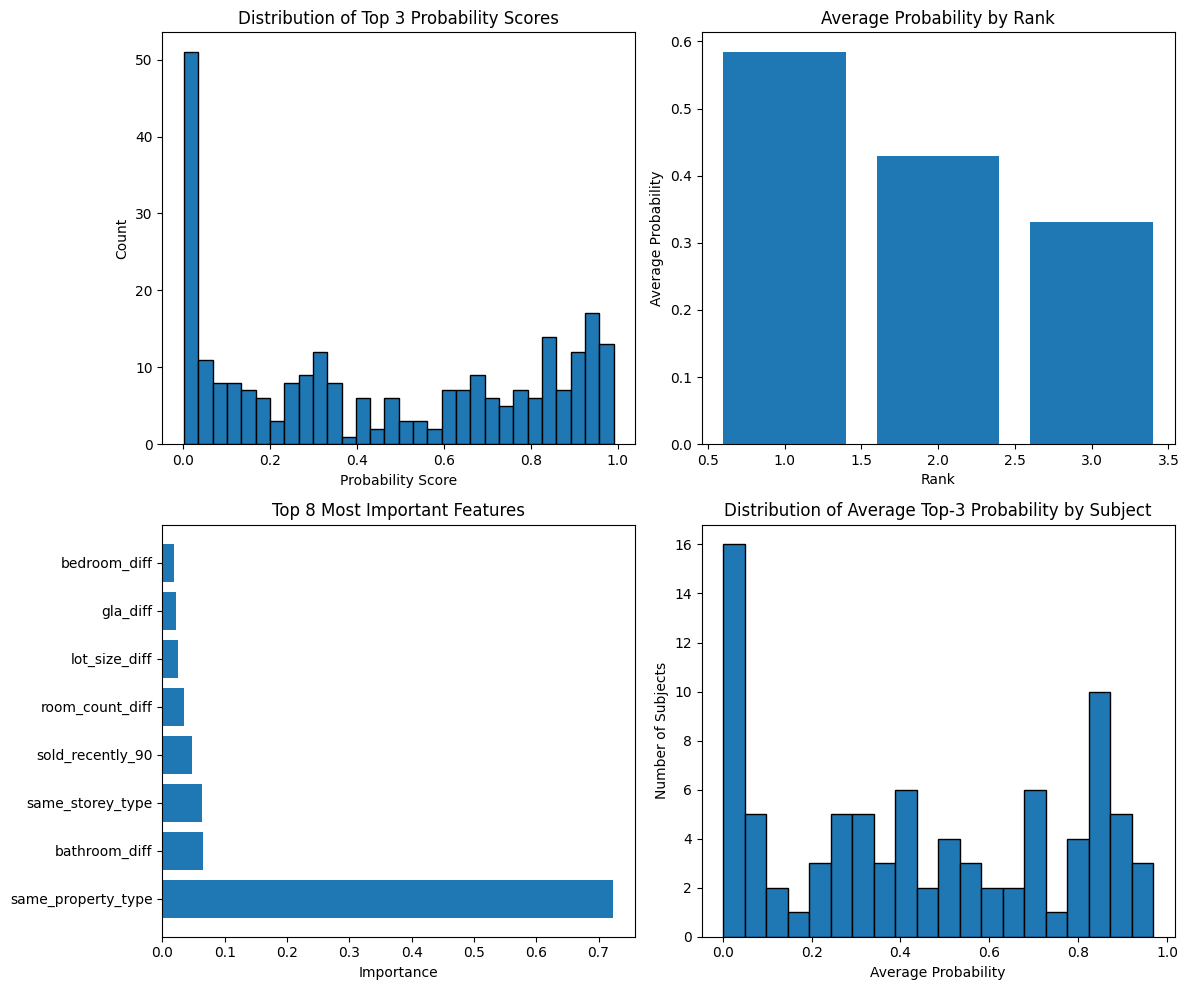


Visualizations saved to 'comparable_analysis_visualizations.png'


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution of top 3 probability scores
axes[0, 0].hist(top_3_detailed_df['probability_score'], bins=30, edgecolor='black')
axes[0, 0].set_title('Distribution of Top 3 Probability Scores')
axes[0, 0].set_xlabel('Probability Score')
axes[0, 0].set_ylabel('Count')

# 2. Average probability by rank
rank_avg = top_3_detailed_df.groupby('rank')['probability_score'].mean()
axes[0, 1].bar(rank_avg.index, rank_avg.values)
axes[0, 1].set_title('Average Probability by Rank')
axes[0, 1].set_xlabel('Rank')
axes[0, 1].set_ylabel('Average Probability')

# 3. Feature importance
top_features = feature_importance.head(8)
axes[1, 0].barh(top_features['Feature'], top_features['Importance'])
axes[1, 0].set_title('Top 8 Most Important Features')
axes[1, 0].set_xlabel('Importance')

# 4. Subjects by average top-3 probability
subject_avg = summary_stats_df['avg_probability_top3'].values
axes[1, 1].hist(subject_avg, bins=20, edgecolor='black')
axes[1, 1].set_title('Distribution of Average Top-3 Probability by Subject')
axes[1, 1].set_xlabel('Average Probability')
axes[1, 1].set_ylabel('Number of Subjects')

plt.tight_layout()
plt.savefig('../data/results/comparable_analysis_visualizations.png', dpi=300)
plt.show()

print("\nVisualizations saved to 'comparable_analysis_visualizations.png'")